In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

In [3]:
ROOT = 'D:/Documents/checkpoints'

In [4]:
def visualize(path: str, deblocking: bool = False):
    df = pd.read_hdf(f'{path}/compression_metrics.h5')

    paths = glob.glob(os.path.join(path, '*.png'))[:2]
    images = list(map(lambda path: Image.open(path), paths))

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Images')
    ax[0].imshow(images[0])
    ax[1].imshow(images[1])

    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle('Metrics of PSNR, MS_SSIM, bpp')

    psnr = df['PSNR_deblocked'] if deblocking else df['PSNR']
    ax[0][0].hist(psnr)
    ax[0][0].set_title(f'PSNR density $\mu={psnr.mean():.2f}$')

    ms_ssim = df['MS_SSIM_deblocked'] if deblocking else df['MS_SSIM']
    ax[0][1].hist(ms_ssim)
    ax[0][1].set_title(f'MS_SSIM density $\mu={ms_ssim.mean():.4f}$')

    ax[1][0].scatter(df['q_bpp'], df['PSNR'])
    ax[1][0].set_title('PSNR / bpp scatter')

    ax[1][1].scatter(df['q_bpp'], df['MS_SSIM'])
    ax[1][1].set_title('MS_SSIM / bpp scatter')

    return psnr.mean(), ms_ssim.mean(), df['q_bpp'].mean()

In [5]:
means = []

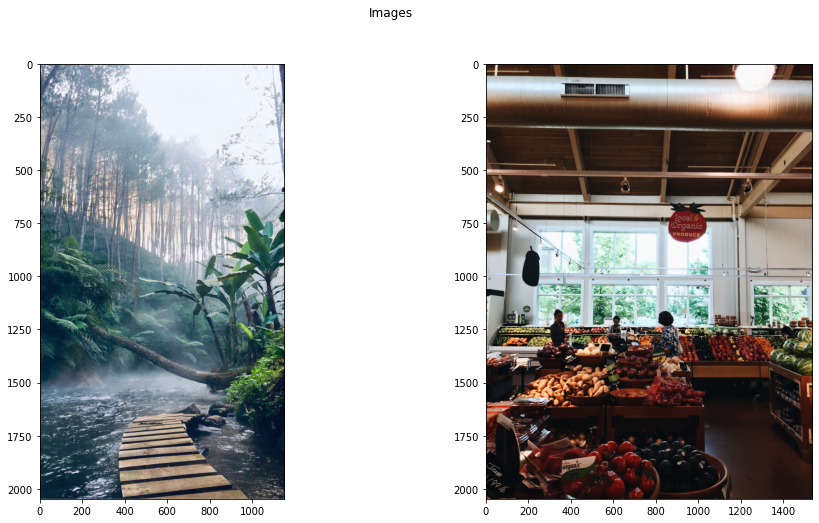

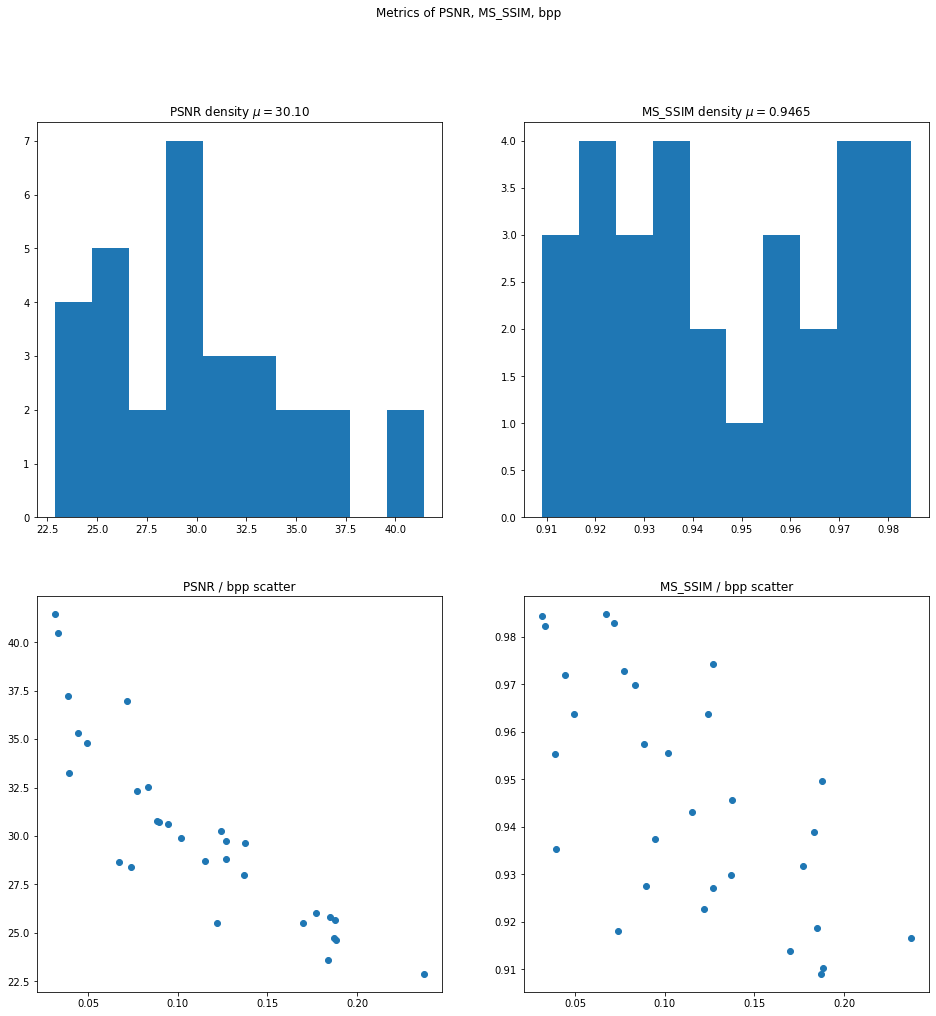

In [6]:
means += visualize(f'{ROOT}/low')

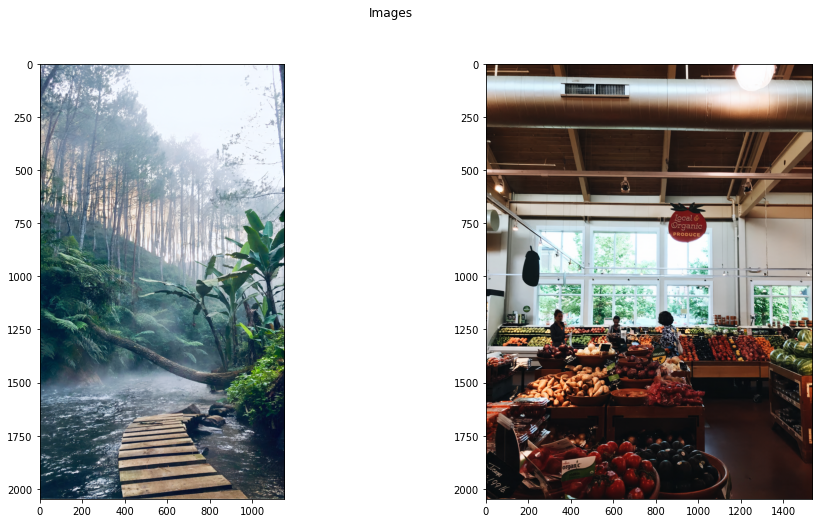

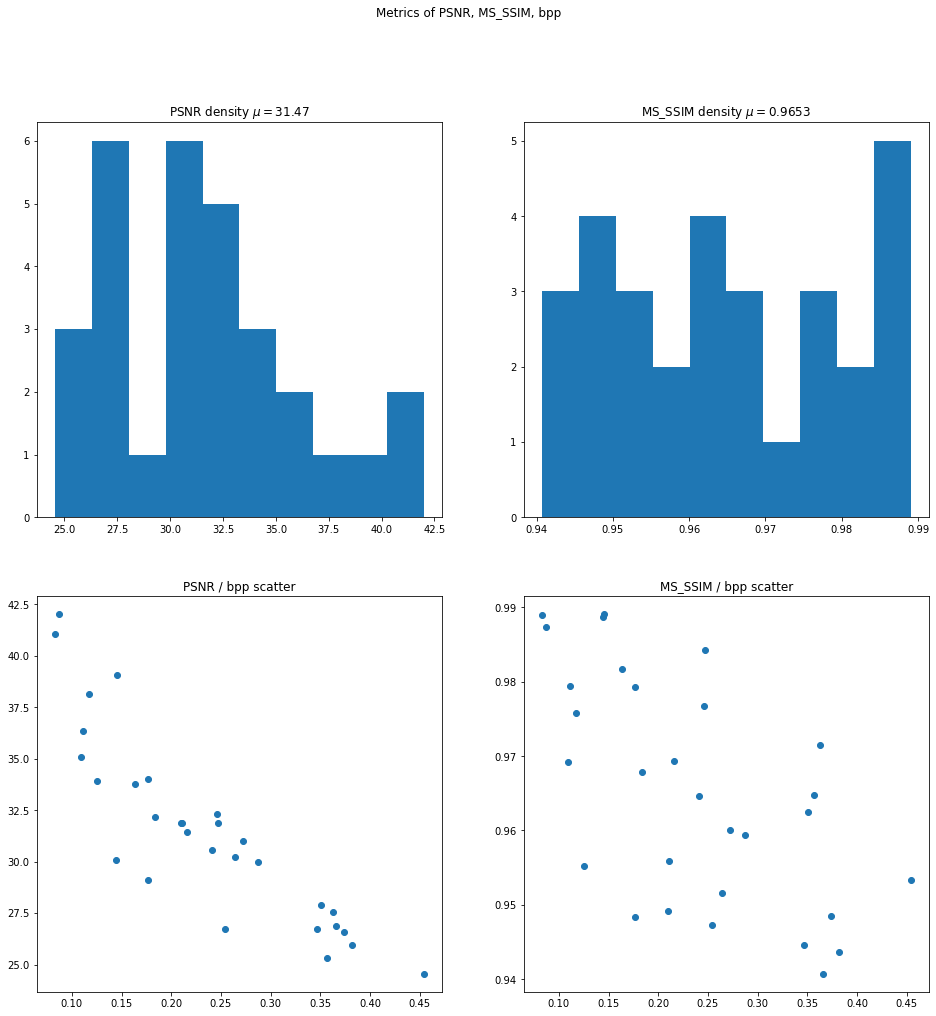

In [7]:
means += visualize(f'{ROOT}/med')

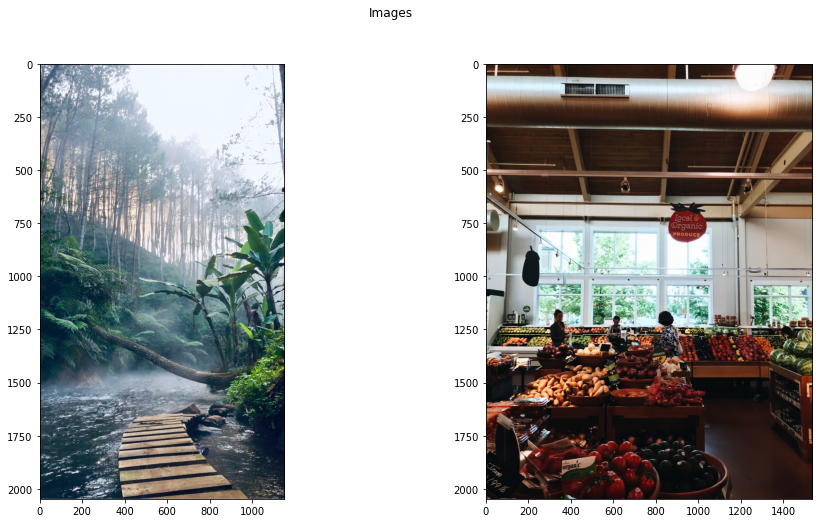

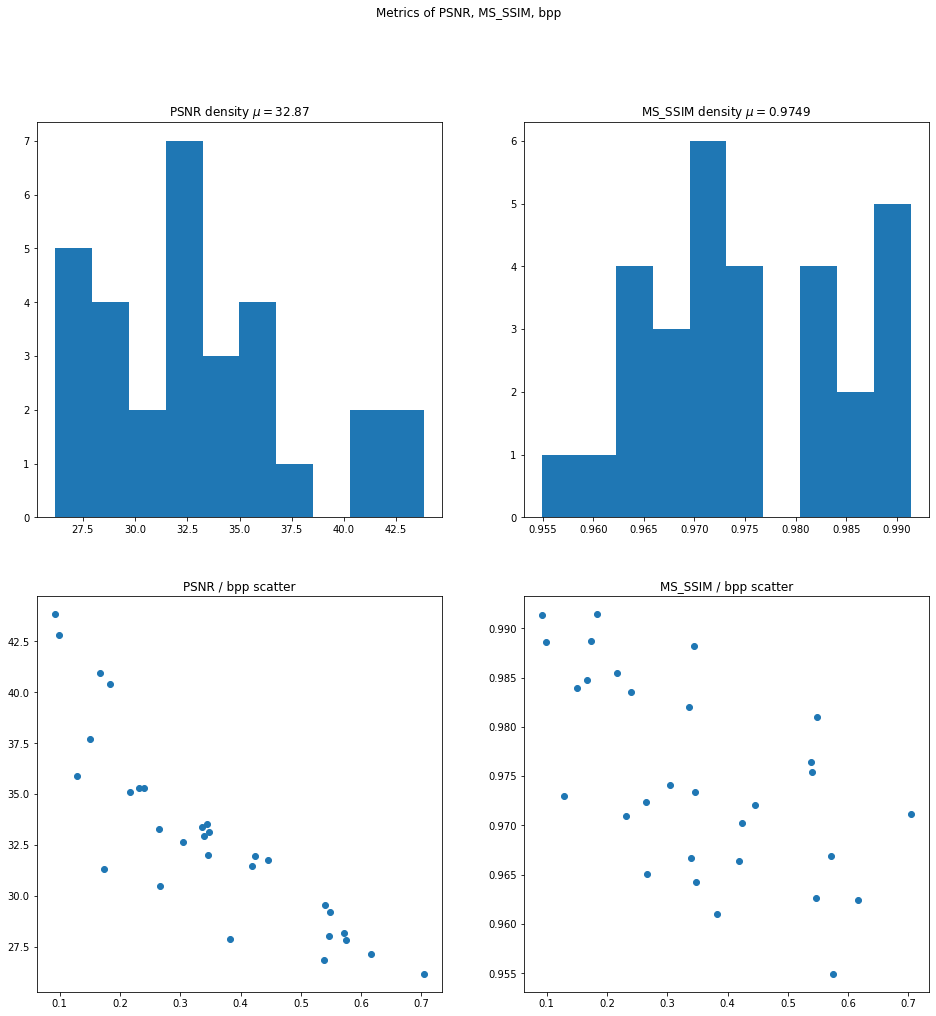

In [8]:
means += visualize(f'{ROOT}/hi')

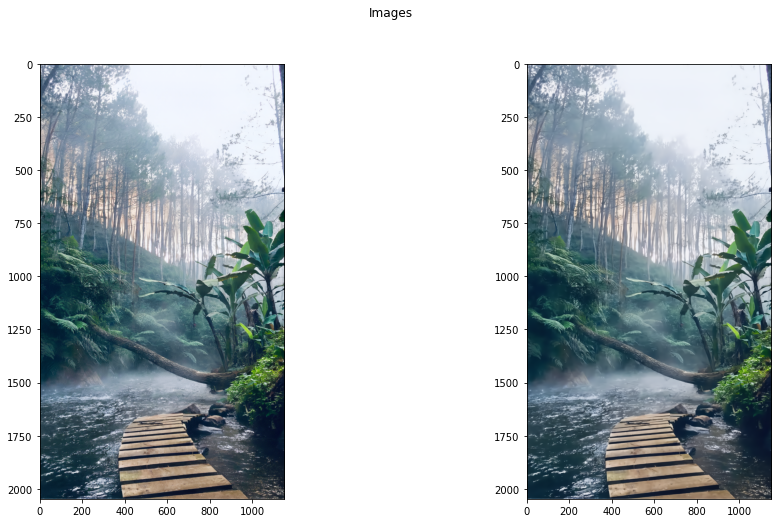

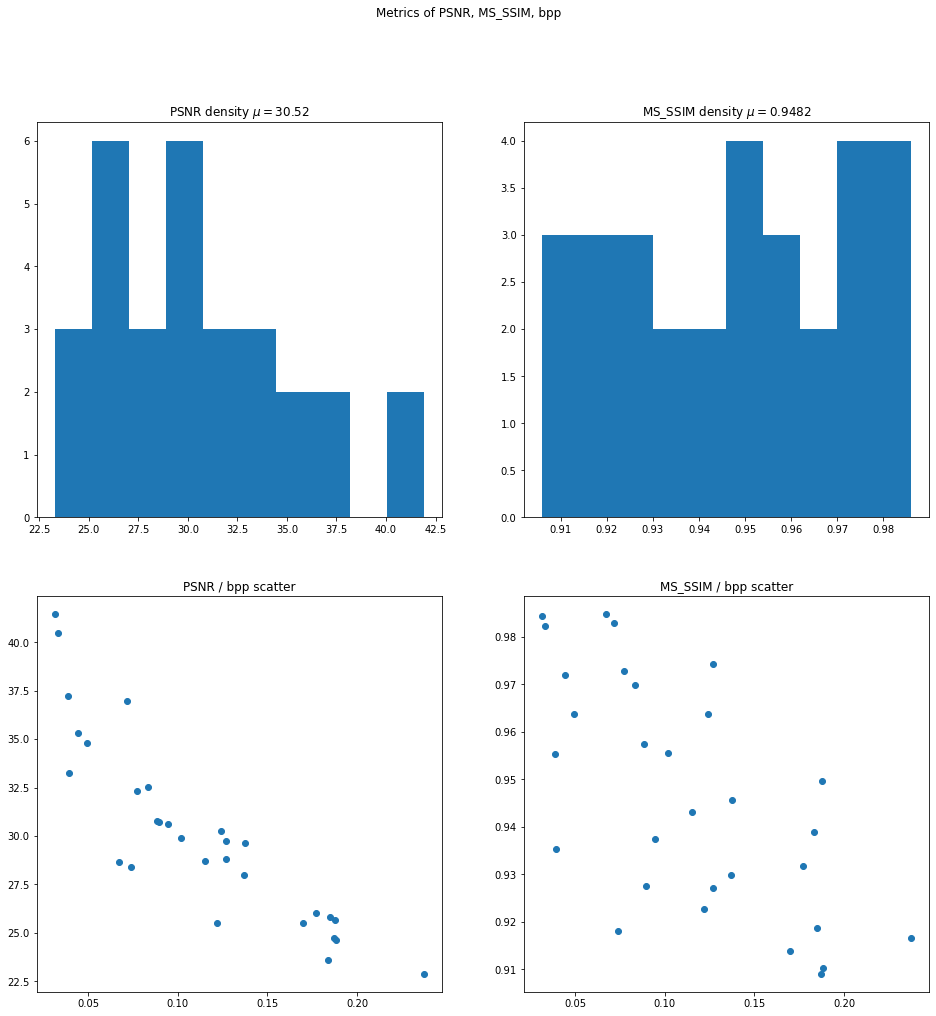

In [9]:
means += visualize(f'{ROOT}/ircnn/reconstructions_deblocking_low', True)

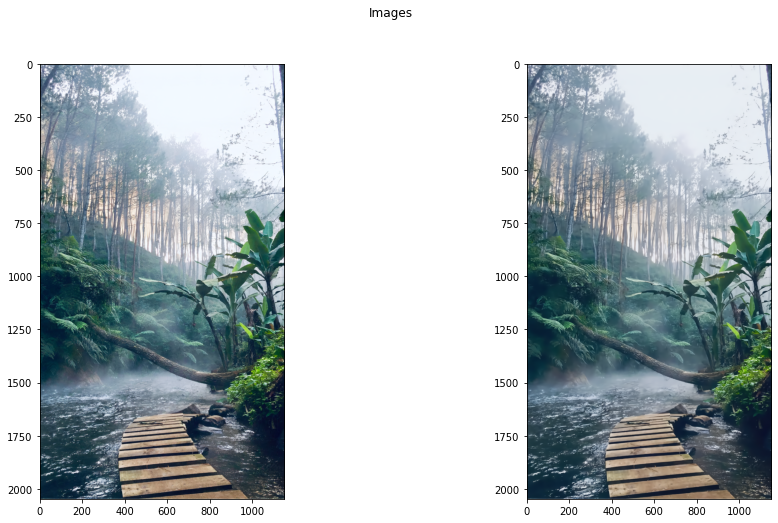

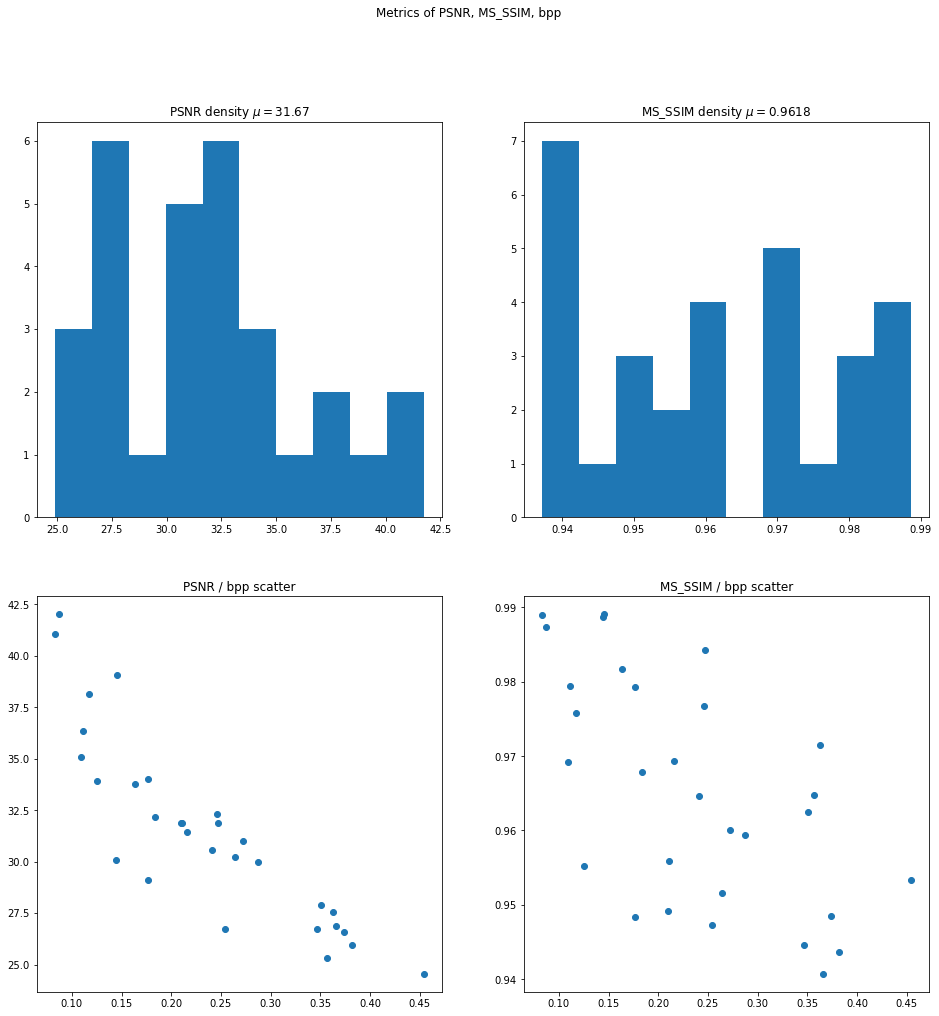

In [10]:
means += visualize(f'{ROOT}/ircnn/reconstructions_deblocking_med', True)

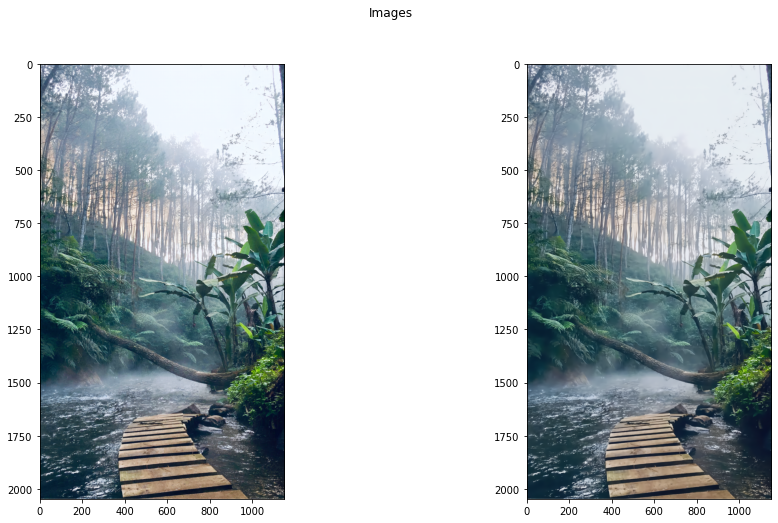

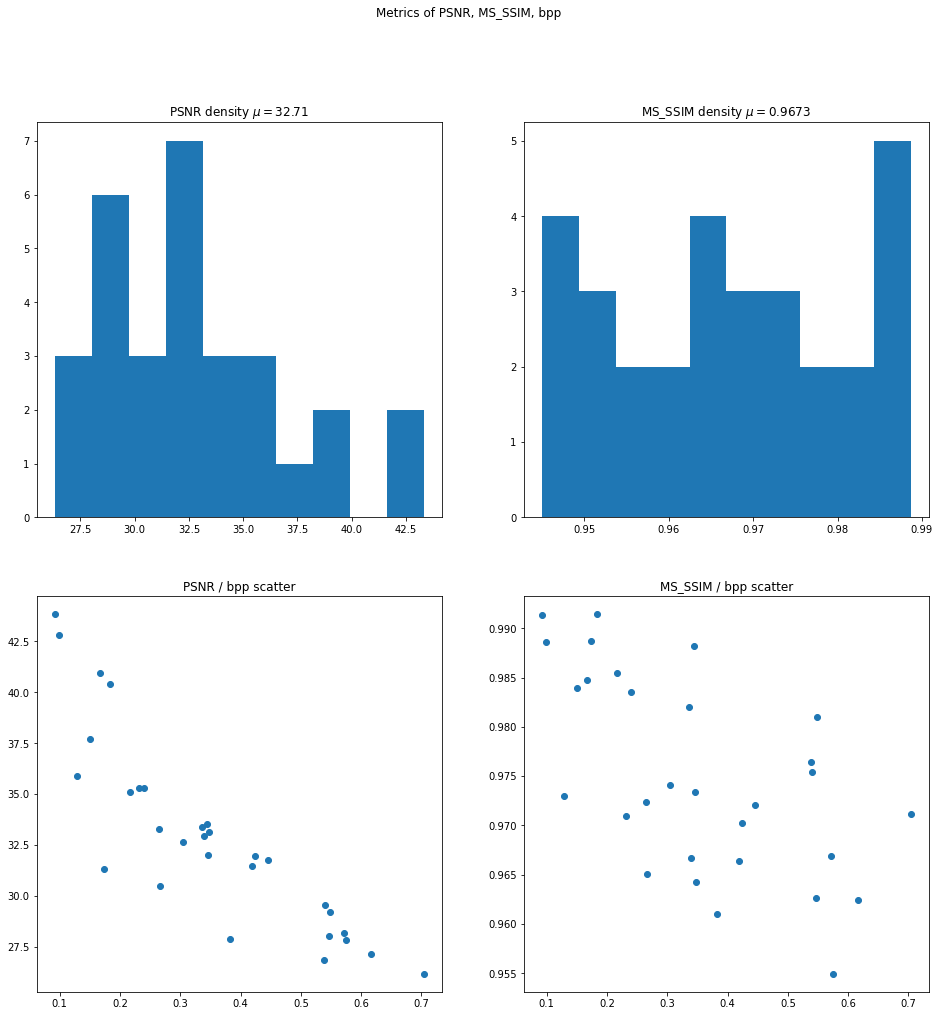

In [11]:
means += visualize(f'{ROOT}/ircnn/reconstructions_deblocking_hi', True)

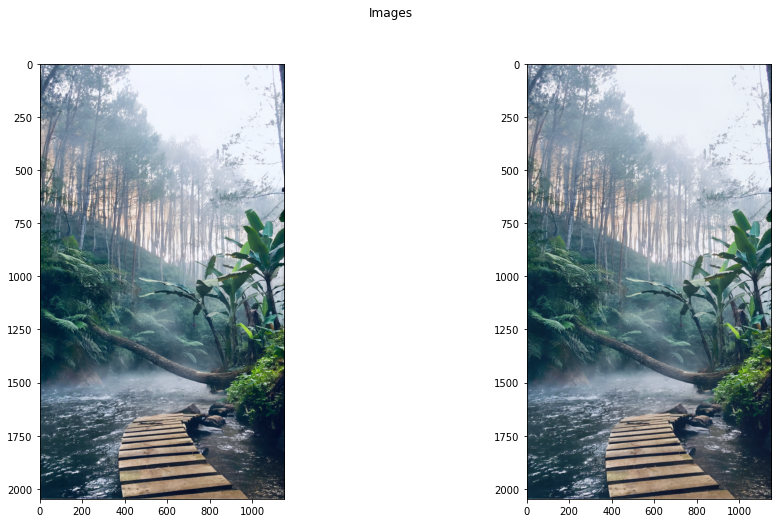

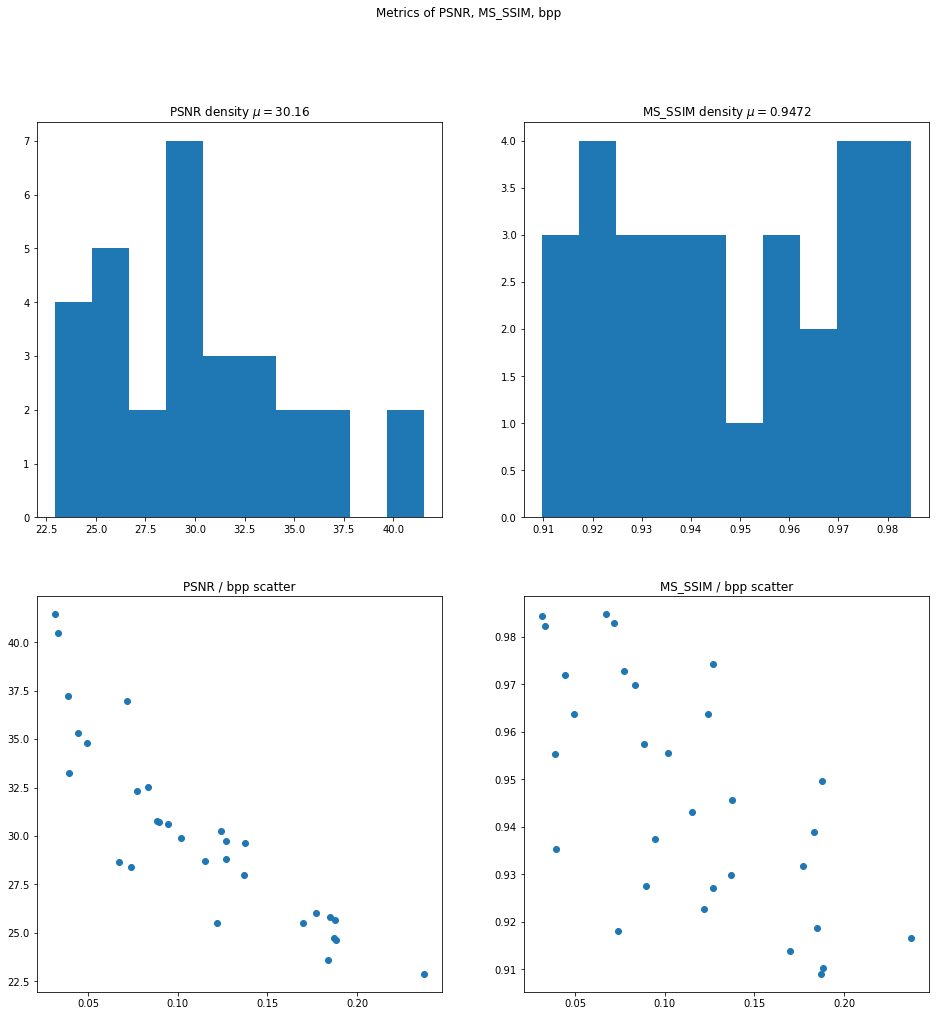

In [12]:
means += visualize(f'{ROOT}/kiar/reconstructions_deblocking_low', True)

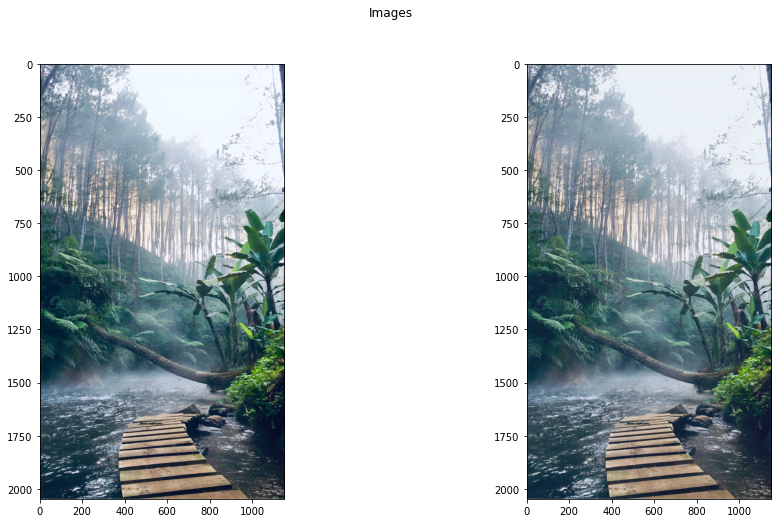

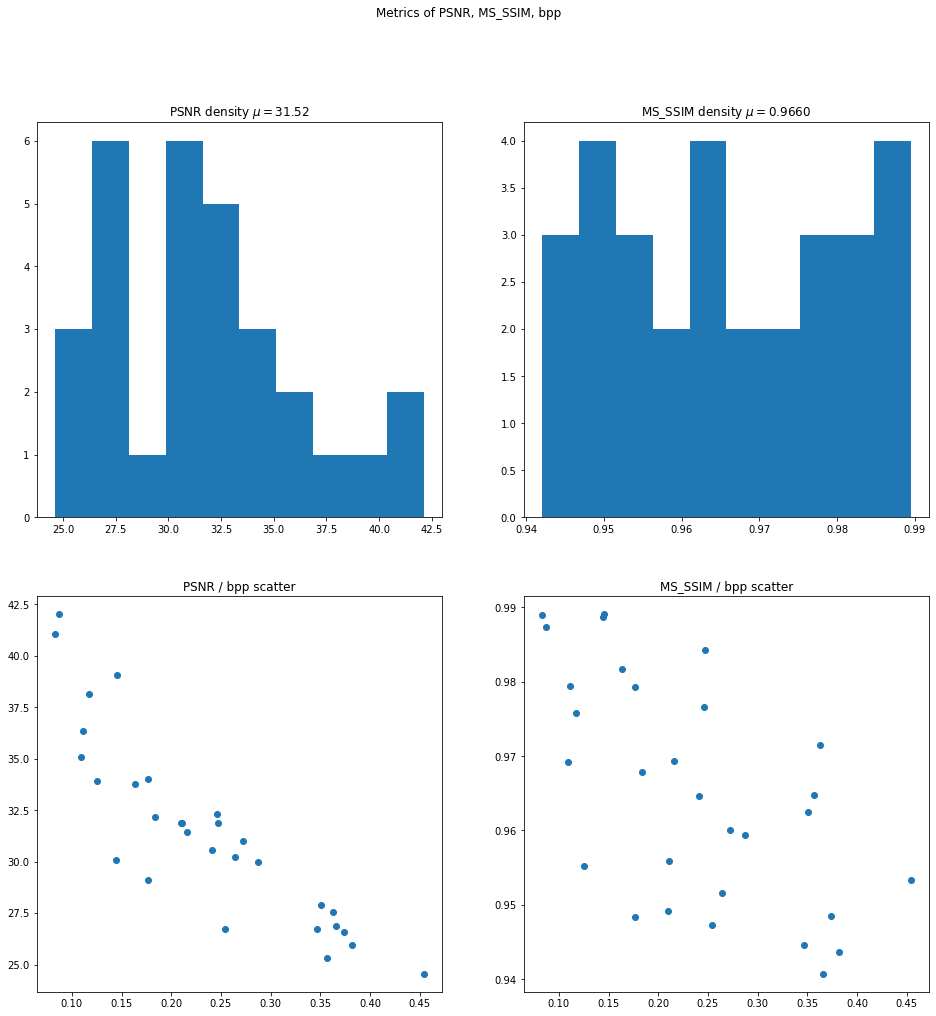

In [13]:
means += visualize(f'{ROOT}/kiar/reconstructions_deblocking_med', True)

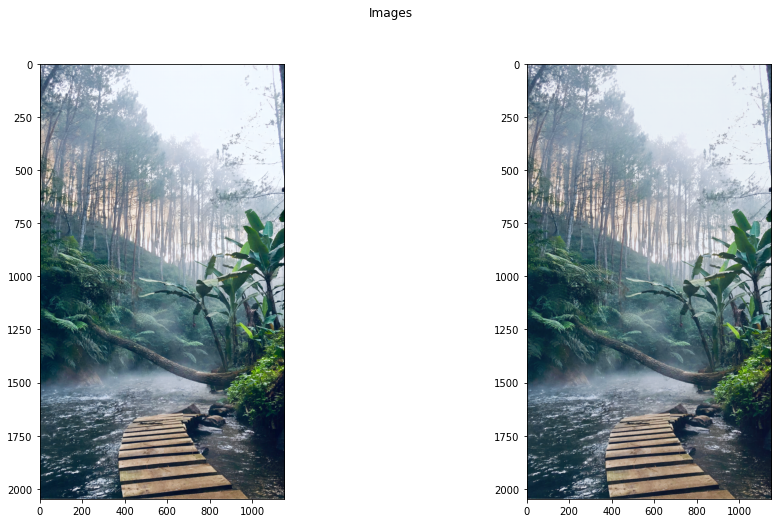

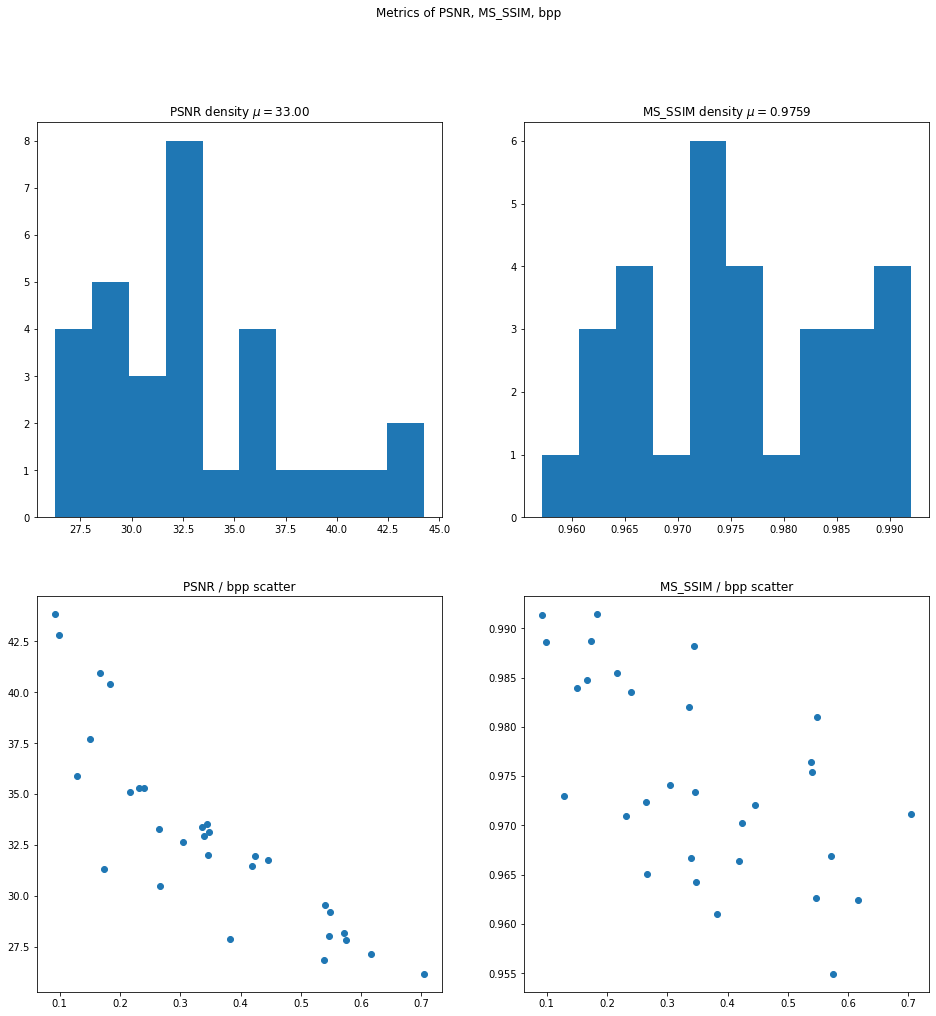

In [14]:
means += visualize(f'{ROOT}/kiar/reconstructions_deblocking_hi', True)

Text(0.5, 1.0, 'PSNR / bpp')

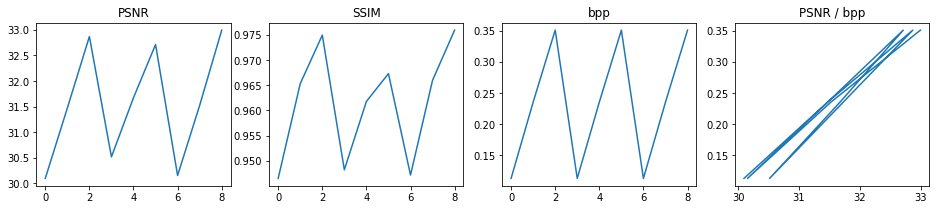

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))

ax[0].plot([i for i in range(len(means[::3]))], list(means[::3]))
ax[0].set_title('PSNR')
ax[1].plot([i for i in range(len(means[1::3]))], list(means[1::3]))
ax[1].set_title('SSIM')
ax[2].plot([i for i in range(len(means[2::3]))], list(means[2::3]))
ax[2].set_title('bpp')
ax[3].plot(means[::3], means[2::3])
ax[3].set_title('PSNR / bpp')


In [16]:
means

[30.097954,
 0.9464909,
 0.113041036,
 31.471,
 0.9652978,
 0.23543666,
 32.8705,
 0.97494406,
 0.35118166,
 30.518568,
 0.9482025,
 0.113041036,
 31.67459,
 0.96177316,
 0.23543666,
 32.71366,
 0.96730113,
 0.35118172,
 30.15531,
 0.94715714,
 0.11304104,
 31.524096,
 0.9659784,
 0.23543668,
 32.99555,
 0.9759378,
 0.3511817]

Text(0, 0.5, 'Pike signal to noise ration (PSNR)')

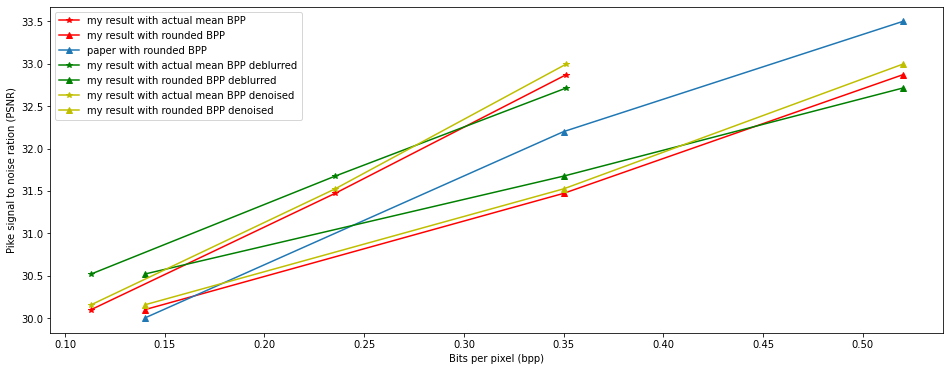

In [22]:
psnr_means = means[::3]

original = [30, 32.2, 33.5]
original_bpp = [0.14, 0.35, 0.52]

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(means[2::3][:3], psnr_means[:3], "*-r")
ax.plot(original_bpp, psnr_means[:3], "^-r")
ax.plot(original_bpp, original, "^-")
ax.plot(means[2::3][3:6], psnr_means[3:6], "*-g")
ax.plot(original_bpp, psnr_means[3:6], "^-g")
ax.plot(means[2::3][6:9], psnr_means[6:9], "*-y")
ax.plot(original_bpp, psnr_means[6:9], "^-y")
ax.legend([
    "my result with actual mean BPP",
    "my result with rounded BPP",
    "paper with rounded BPP",
    "my result with actual mean BPP deblurred",
    "my result with rounded BPP deblurred",
    "my result with actual mean BPP denoised",
    "my result with rounded BPP denoised",
])
ax.set_xlabel("Bits per pixel (bpp)")
ax.set_ylabel("Pike signal to noise ration (PSNR)")

In [ ]:
import torch
from deblocking.CNNs.mymodel import ARCNN, ARDenseNet, L8
from deblocking.MultiScale.MS_model import IntraDeblocking
import torchsummary

parameters = [
    r'D:\Documents\project\thesis\deblocking\model_parameters\MSqp42-124-0.001293-29.0237-0.8455param.pth',
    r'D:\Documents\project\thesis\deblocking\model_parameters\L8_qp42-99-0.001374-28.6387-0.8429param.pth'
]

models = [
    IntraDeblocking, L8
]

model = models[0]()
model.load_state_dict(torch.load(parameters[0]))
model.to(torch.device('cuda'))

torchsummary.summary(model, (1, 3, 64, 64), 8, device='cuda')

INPUT : torch.Size([1, 3, 128, 192])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


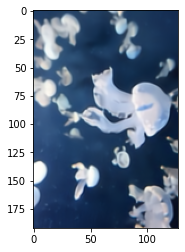

In [5]:
from PIL import Image
from torchvision import transforms as T

image = Image.open(r'D:\Documents\project\thesis\data\reconstructions\alberto-montalesi-176097_RECON_0.068bpp.png')
transform = T.Compose([
    T.Resize((128,)),
    T.ToTensor()
])
image = transform(image.convert('RGB')).cuda()

input = image.unsqueeze(0) # torch.rand((1, 3, 64, 64)).cuda()
print(f'INPUT : {input.shape}')
output = model(input).detach().cpu()

import matplotlib.pyplot as plt

plt.imshow(output[0].transpose(0, 2))

In [ ]:
import torch
from KAIR.models.network_dncnn import DnCNN, IRCNN


#model = DnCNN(in_nc=3, out_nc=3, nc=64, nb=20, act_mode='R')
model = IRCNN(in_nc=3, out_nc=3)
checkpoint = torch.load('D:/Documents/checkpoints/kiar/ircnn_color.pth')
print(checkpoint)
model.load_state_dict(checkpoint['10'])
model.to('cuda')

model(torch.rand((1, 3, 64, 64), device='cuda'))


In [ ]:
import torch
from DeblurGANv2.models.fpn_inception import FPNInception

model = FPNInception()


In [23]:
import torch
from deblocking.MultiScale.MS_model import IntraDeblocking

model = IntraDeblocking()

model.load_state_dict(torch.load(r'D:\Documents\project\thesis\deblocking\model_parameters\MSqp42-124-0.001293-29.0237-0.8455param.pth'))

<All keys matched successfully>